# Impact calculations with data from OpenStreetMap
## Paper Sketch openstreetmap & lines_polys_handler modules

In [2]:
import matplotlib.pyplot as plt
import shapely
import contextily as ctx
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd

from climada.util.api_client import Client
import climada.util.lines_polys_handler as u_lp
from climada.engine.impact_calc import ImpactCalc
from climada.entity.impact_funcs import ImpactFuncSet, ImpactFunc
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity import Exposures
from climada.entity import LitPop
from climada import CONFIG

from climada_petals.entity.exposures.openstreetmap.osm_dataloader import OSMRaw, OSMFileQuery
from climada_petals.entity.exposures.openstreetmap.osm_dataloader import DICT_CIS_OSM

### Getting OSM Files

In [3]:
# download osm.pbf file for Switzerland from geofabrik
DATA_DIR = CONFIG.exposures.openstreetmap.local_data.dir()
OSMRaw().get_data_geofabrik('CHE', file_format='pbf', save_path=DATA_DIR)

2023-03-20 17:59:41,730 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - file already exists as /Users/evelynm/climada/data/openstreetmap/switzerland-latest.osm.pbf


### Extracting geo-data from OSM files

In [8]:
DICT_CIS_OSM.keys()

dict_keys(['education', 'healthcare', 'water', 'telecom', 'road', 'main_road', 'rail', 'air', 'gas', 'oil', 'power', 'wastewater', 'food', 'buildings'])

In [4]:
# Initiate a OSMFileQuery instance with path to the downloaded file
SwissFileQuery = OSMFileQuery(Path(DATA_DIR,'switzerland-latest.osm.pbf'))

## Healthcare infrastructure

In [27]:
gdf_health = SwissFileQuery.retrieve_cis('healthcare')

2023-03-20 18:12:29,900 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract points: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1926/1926 [00:22<00:00, 83.95it/s]

2023-03-20 18:13:16,430 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop



extract multipolygons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1403/1403 [01:07<00:00, 20.92it/s]
/Users/evelynm/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:560: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(


In [ ]:
# plot results
ax = gdf_health.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='red', 
                    edgecolor='red', label='health facilities')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Healthcare Facilities Switzerland', fontsize=25)
ctx.add_basemap(ax)
plt.show()

## Education, or Airports (or similar)

In [26]:
gdf_airports = SwissFileQuery.retrieve_cis('air')

2023-03-20 18:11:01,340 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract multipolygons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:41<00:00,  2.78s/it]


In [39]:
# plot results
ax = gdf_airports.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='brown', 
                    edgecolor='red', label='airports')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Airports  Switzerland', fontsize=25)
ctx.add_basemap(ax)
plt.show()

## Railways

In [5]:
osm_keys=['railway', 'name']
osm_query="railway='rail' or railway='tram' or railway='light_rail' or railway='narrow_gauge'"

gdf_rails = SwissFileQuery.retrieve('lines', osm_keys, osm_query)

2023-03-20 17:59:53,774 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50514/50514 [00:20<00:00, 2453.62it/s]


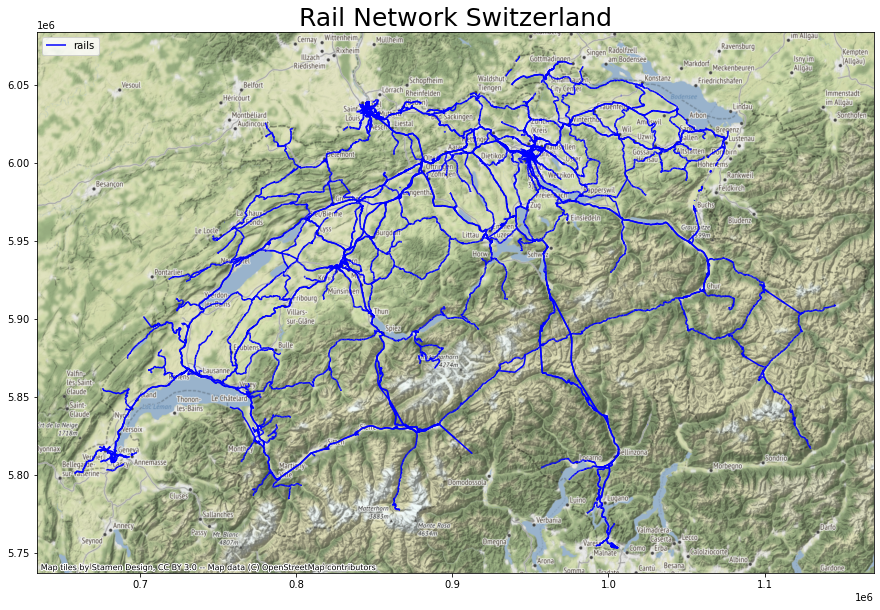

In [7]:
# plot results
ax = gdf_rails.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='blue', 
                    edgecolor='blue', label='rails')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Rail Network Switzerland', fontsize=25)
ctx.add_basemap(ax)
plt.show()

## Forests 

In [6]:
# Forests in Switzerland
osm_keys = ['landuse']
osm_query = "landuse='forest'"
gdf_forest = SwissFileQuery.retrieve('multipolygons', osm_keys, osm_query)

2023-03-20 18:00:36,503 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract multipolygons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76090/76090 [00:48<00:00, 1584.87it/s]


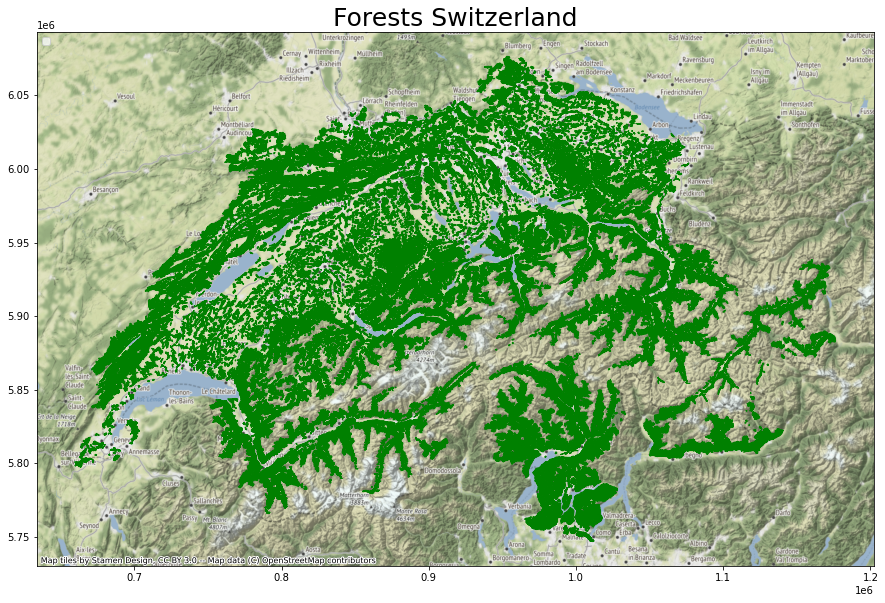

In [33]:
# plot results
ax = gdf_forest.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='green', 
                    edgecolor='green', label='forest')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Forests Switzerland', fontsize=25)
ctx.add_basemap(ax)
plt.show()

In [7]:
# do some cleaning: only valid shapes, not very tiny ones
import shapely
def make_valid(geometry):
    if geometry.is_valid:
        return geometry
    return geometry.buffer(0.0001)

In [8]:
gdf_forest['geometry'] = gdf_forest.apply(lambda row: make_valid(row.geometry), axis=1)
gdf_forest = gdf_forest[gdf_forest['geometry'].area > 1e-5]

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  numbe

In [ ]:
# consumes too much memory
# shapely.ops.unary_union(gdf_forest.geometry)
# shapely.ops.unary_union(gdf_forest['geometry'][gdf_forest['geometry'].type=='MultiPolygon'])

### Loading Hazard Data

In [9]:
# Let's take european winter storms
client = Client()
ws_che = client.get_hazard('storm_europe', properties={'country_name': 'Switzerland'})
ws_che = ws_che.select(orig=True)

2023-03-20 18:03:04,036 - climada.hazard.base - INFO - Reading /Users/evelynm/climada/data/hazard/storm_europe/storm_europe_150arcsec_CHE/v1/WISC_prob_CHE.hdf5


In [58]:
print(datetime.fromordinal(int(np.min(ws_che.date))))
print(datetime.fromordinal(int(np.max(ws_che.date))))

1940-11-01 00:00:00
2013-12-05 00:00:00


In [10]:
# Lothar happened around Dec 26, 1999
date_lothar_start = datetime(1999, 12, 25)
date_lothar_end = datetime(1999, 12, 31)

date_lothar_start_ordinal = date_lothar_start.toordinal()
date_lothar_end_ordinal = date_lothar_end.toordinal()

In [11]:
ws_lothar = ws_che.select(date=[date_lothar_start_ordinal, date_lothar_end_ordinal])

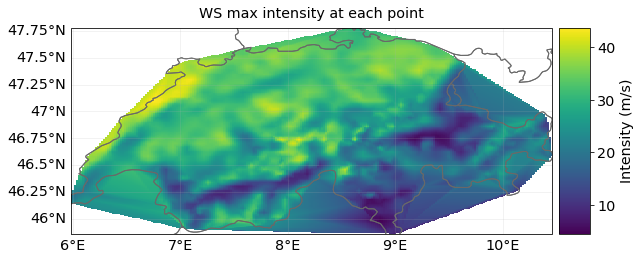

In [23]:
ws_lothar.plot_intensity(0)
# ugly work-around for making eai_exp plot an at_event plot later --> frequency = 1
ws_lothar.frequency = np.array([1])

In [61]:
# Vivian happened around Feb 27, 1990
date_vivian_start = datetime(1990, 2, 26)
date_vivian_end = datetime(1990, 2, 28)

date_vivian_start_ordinal = date_vivian_start.toordinal()
date_vivian_end_ordinal = date_vivian_end.toordinal()

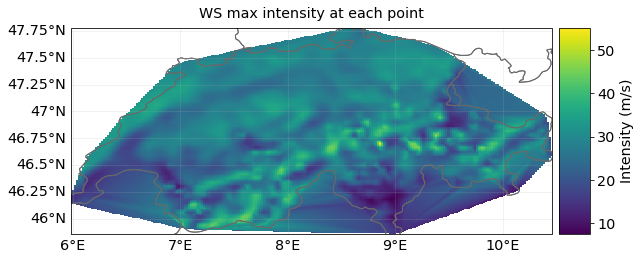

In [62]:
ws_vivian = ws_che.select(date=[date_vivian_start_ordinal, date_vivian_end_ordinal])
ws_vivian.plot_intensity(0)
# ugly work-around for making eai_exp plot an at_event plot later --> frequency = 1
ws_vivian.frequency = np.array([1])

### Impact Calculations for Line & Polygon data

### Defining impact functions

In [12]:
impf_set = ImpactFuncSet()

<AxesSubplot:title={'center':'WS 1: Welker 2021'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

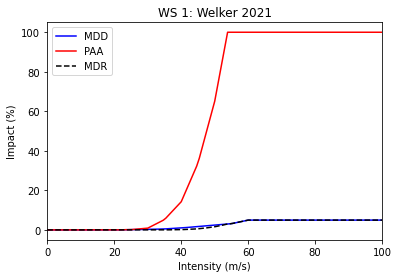

In [13]:
impf_set.append(ImpfStormEurope.from_welker())
impf_set.check()
impf_set.plot()

array([<AxesSubplot:title={'center':'WS 1: Welker 2021'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 2: '}, xlabel='Intensity ()', ylabel='Impact (%)'>],
      dtype=object)

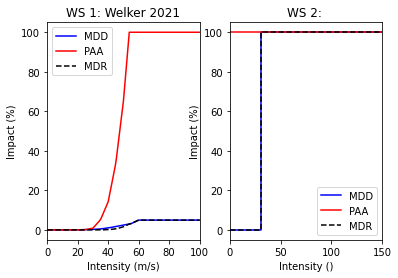

In [14]:
impf_thresh = ImpactFunc.from_step_impf([0,30.5,150],impf_id=2) # start of warning level 4 MCH
impf_thresh.haz_type = 'WS'
impf_set.append(impf_thresh)
impf_set.check()
impf_set.plot()

array([<AxesSubplot:title={'center':'WS 1: Welker 2021'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 2: '}, xlabel='Intensity ()', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 3: '}, xlabel='Intensity ()', ylabel='Impact (%)'>],
      dtype=object)

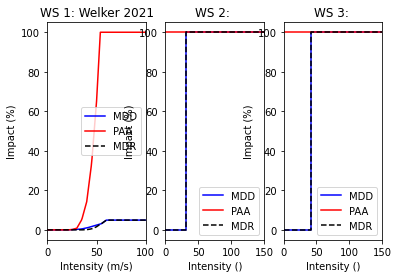

In [15]:
impf_threeblow = ImpactFunc.from_step_impf([0,42,150],impf_id=3) # tree blowdown fund
impf_threeblow.haz_type = 'WS'
impf_set.append(impf_threeblow)
impf_set.check()
impf_set.plot()

### Exposures from gdfs

In [28]:
exp_health = Exposures(gdf_health)
exp_health.gdf['impf_WS'] = 2
exp_health.gdf['value'] = 1
exp_health.gdf['geometry'] = exp_health.gdf.geometry.centroid # simplify to points
exp_health.set_lat_lon()
exp_health.check()

2023-03-20 18:15:34,342 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.


/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_19417/3092231282.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_health.gdf['geometry'] = exp_health.gdf.geometry.centroid # simplify to points


2023-03-20 18:15:34,424 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-20 18:15:34,425 - climada.entity.exposures.base - INFO - cover not set.
2023-03-20 18:15:34,426 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-20 18:15:34,426 - climada.entity.exposures.base - INFO - region_id not set.
2023-03-20 18:15:34,427 - climada.entity.exposures.base - INFO - centr_ not set.


In [29]:
exp_airports = Exposures(gdf_airports)
exp_airports.gdf['impf_WS'] = 2

In [16]:
# Making exposures with non-point geometry data:
exp_rails = Exposures(gdf_rails)
exp_rails.gdf['impf_WS'] = 2

In [17]:
exp_forest = Exposures(gdf_forest)
exp_forest.gdf['impf_WS'] = 3

### Exposures from LitPop

In [30]:
# asset values (1,1)
exp_lp = LitPop().from_countries(['CHE'])
exp_lp.gdf['impf_WS'] = 1

2023-03-20 18:15:34,715 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CHE (756)...

2023-03-20 18:15:38,851 - climada.util.finance - INFO - GDP CHE 2014: 7.265e+11.
2023-03-20 18:15:39,304 - climada.util.finance - INFO - GDP CHE 2018: 7.256e+11.
2023-03-20 18:15:39,335 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2023-03-20 18:15:39,336 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-20 18:15:39,337 - climada.entity.exposures.base - INFO - cover not set.
2023-03-20 18:15:39,338 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-20 18:15:39,339 - climada.entity.exposures.base - INFO - centr_ not set.


In [31]:
# population gridded counts (0,1)
exp_pop = LitPop().from_countries(['CHE'], exponents=(0, 1), fin_mode='pop')
exp_pop.gdf['impf_WS'] = 2

2023-03-20 18:15:39,612 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CHE (756)...

2023-03-20 18:15:43,249 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2023-03-20 18:15:43,251 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-20 18:15:43,251 - climada.entity.exposures.base - INFO - cover not set.
2023-03-20 18:15:43,252 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-20 18:15:43,253 - climada.entity.exposures.base - INFO - centr_ not set.


### Impact calculations

2023-03-20 18:15:43,259 - climada.entity.exposures.base - INFO - Matching 3329 exposures with 3057 centroids.
2023-03-20 18:15:43,262 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-20 18:15:43,274 - climada.engine.impact_calc - INFO - Calculating impact for 9987 assets (>0) and 1 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

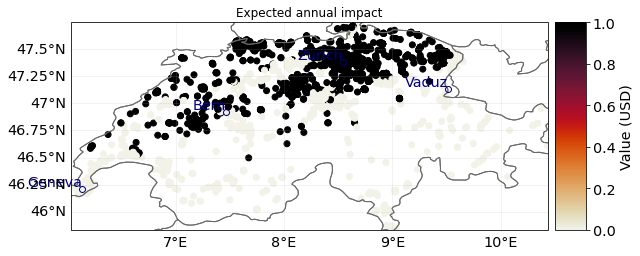

In [32]:
imp_health = ImpactCalc(exp_health, impf_set, ws_lothar).impact()
imp_health.plot_scatter_eai_exposure()

2023-03-20 18:15:45,105 - climada.util.lines_polys_handler - WARNING - Polygon smaller than resolution. Setting a representative point.
2023-03-20 18:15:45,239 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-20 18:15:45,277 - climada.entity.exposures.base - INFO - Matching 1368 exposures with 3057 centroids.
2023-03-20 18:15:45,278 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-20 18:15:45,285 - climada.engine.impact_calc - INFO - Calculating impact for 4104 assets (>0) and 1 events.


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

<AxesSubplot:>

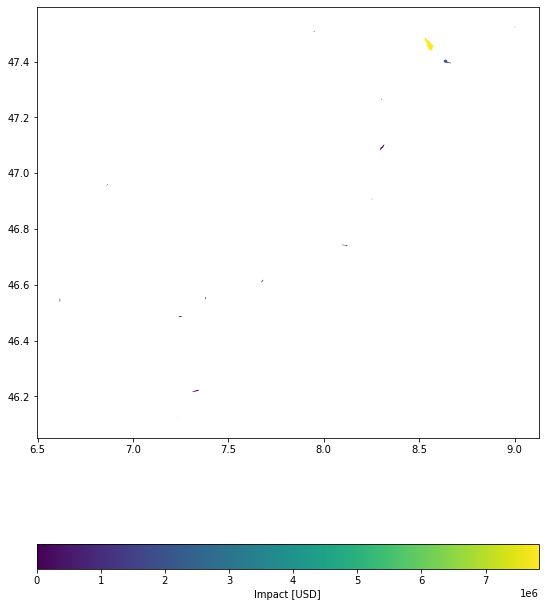

In [33]:
# all-in-one calculation for lines: 
# interpolate to 500 m resolution, assign each point a fixed value of 500 (metres),
# and re-aggregate the sum of damages to the original exposure format

imp_airport = u_lp.calc_geom_impact(
    exp=exp_airports, impf_set=impf_set, haz=ws_lothar,
    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100,
    agg_met=u_lp.AggMethod.SUM)

# plot the impacts
u_lp.plot_eai_exp_geom(imp_airport)

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2023-03-20 18:08:00,495 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-20 18:08:02,977 - climada.entity.exposures.base - INFO - Matching 112398 exposures with 3057 centroids.
2023-03-20 18:08:02,981 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-20 18:08:03,122 - climada.engine.impact_calc - INFO - Calculating impact for 337194 assets (>0) and 1 events.


<AxesSubplot:>

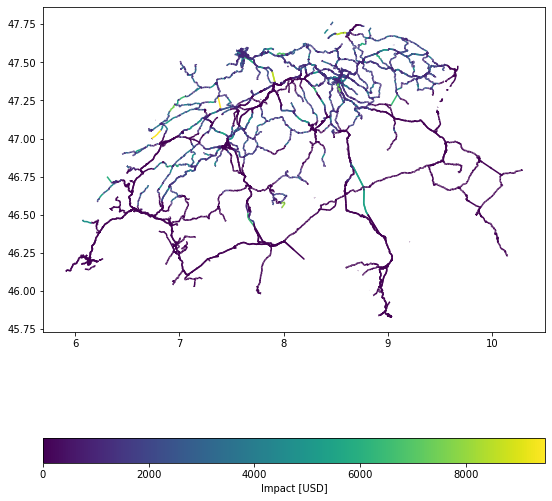

In [24]:
# all-in-one calculation for lines: 
# interpolate to 500 m resolution, assign each point a fixed value of 500 (metres),
# and re-aggregate the sum of damages to the original exposure format
imp_rails = u_lp.calc_geom_impact(
    exp=exp_rails, impf_set=impf_set, haz=ws_lothar,
    res=500, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=500,
    agg_met=u_lp.AggMethod.SUM
)

# plot the impacts
u_lp.plot_eai_exp_geom(imp_rails)

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

2023-03-20 18:10:24,974 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-20 18:10:52,130 - climada.entity.exposures.base - INFO - Matching 1255598 exposures with 3057 centroids.
2023-03-20 18:10:52,154 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-20 18:10:53,672 - climada.engine.impact_calc - INFO - Calculating impact for 3766794 assets (>0) and 1 events.


<AxesSubplot:>

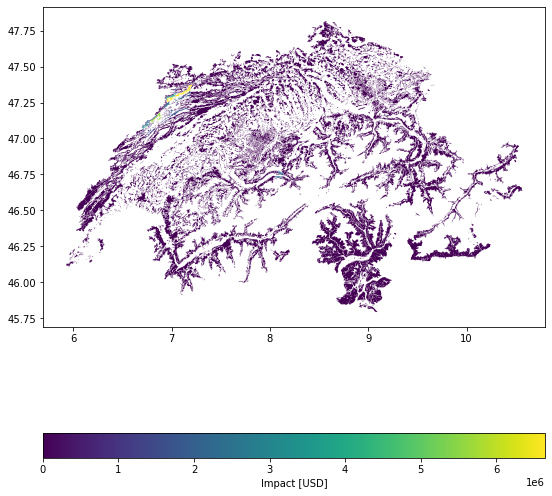

In [25]:
#
# exp_forest_pnt = u_lp.exp_geom_to_pnt(exp=exp_forest, res=100, to_meters=True, 
#                                      disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100)
# exp_forest_pnt.gdf.value.sum() # 12555980000 --> estimated at around 1000000000 by swiss sources indeed

# all-in-one calculation for areas:
# interpolate to 10'000 m2, set value per area-point to this value, re-aggrate to sum of damages.

imp_forest = u_lp.calc_geom_impact(
    exp=exp_forest, impf_set=impf_set, haz=ws_lothar,
    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100,
    agg_met=u_lp.AggMethod.SUM
)

# plot results.
u_lp.plot_eai_exp_geom(imp_forest)

2023-03-20 18:15:45,495 - climada.entity.exposures.base - INFO - Matching 70287 exposures with 3057 centroids.
2023-03-20 18:15:45,498 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-20 18:15:45,575 - climada.engine.impact_calc - INFO - Calculating impact for 204882 assets (>0) and 1 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

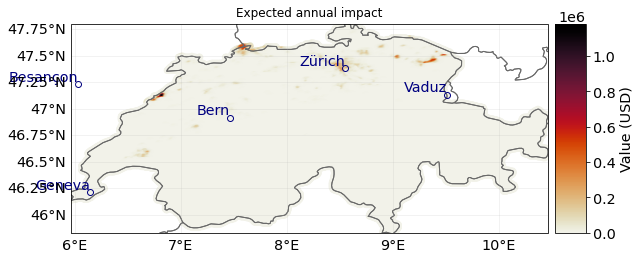

In [34]:
imp_lp = ImpactCalc(exp_lp, impf_set, ws_lothar).impact()
imp_lp.plot_scatter_eai_exposure()

2023-03-20 18:15:48,235 - climada.entity.exposures.base - INFO - Matching 70287 exposures with 3057 centroids.
2023-03-20 18:15:48,238 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-20 18:15:48,314 - climada.engine.impact_calc - INFO - Calculating impact for 204882 assets (>0) and 1 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

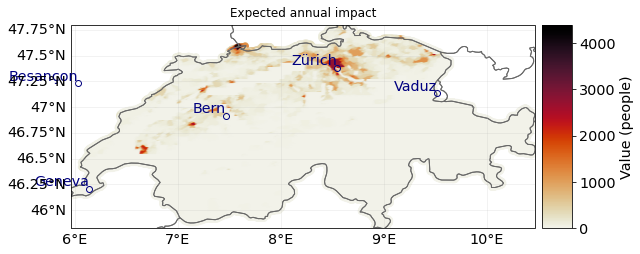

In [35]:
imp_pop = ImpactCalc(exp_pop, impf_set, ws_lothar).impact()
imp_pop.plot_scatter_eai_exposure()

### Summary table

In [36]:
summary_table = pd.DataFrame()
summary_table['exposure'] = ['Asset Values', 'Population', 'Healthcare Facilities', 'Airports',
                             'Railways', 'Forest Area']
summary_table['event_impact'] = [imp.aai_agg for imp in [imp_lp, imp_pop, imp_health, imp_airport,
                                                         imp_rails, imp_forest]]
summary_table['metric'] = ['USD', 'people', 'units', 'm2', 'm', 'm2']

In [37]:
summary_table

exposure  event_impact  metric
0           Asset Values  2.328685e+08     USD
1             Population  4.985987e+06  people
2  Healthcare Facilities  1.843000e+03   units
3               Airports  1.032000e+07      m2
4               Railways  2.844300e+07       m
5            Forest Area  8.072000e+07      m2

In [ ]:
# building damage estimated: 600 million

In [89]:
# reported forest damage: 46000 ha (ca. 4.3% of total forest area)
# Damage value: 750 million 
46000*10000/0.043

10000000000.0

In [38]:
# value per m2 of forest
750*1e6/(46000*10000)

1.6304347826086956

In [92]:
exp_forest.gdf.columns

Index(['osm_id', 'landuse', 'geometry', 'impf_WS'], dtype='object')

In [97]:
12555980000/10000000000

1.255598

In [41]:
8.072000e+07/(46000*10000)

0.17547826086956522

In [46]:
ws_lothar.centroids.coord

array([[45.86035156,  8.94042969],
       [45.86035156,  8.98046875],
       [45.86035156,  9.01953125],
       ...,
       [47.74023438,  8.70019531],
       [47.78027344,  8.58007812],
       [47.78027344,  8.66015625]])